[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrrajeshreddy/TGS-Salt-Identification/blob/master/Models_visualizations.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [0]:
img_shape = (128,128,1)

In [0]:
def simple_model():
  def conv_block(input_tensor, num_filters):
    encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

  def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

  def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder
  
  def get_model():
    inputs = layers.Input(shape=img_shape )
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    center = conv_block(encoder3_pool, 512)
    decoder3 = decoder_block(center, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model
  
  model = get_model()
  model_weight = './gdrive/My Drive/model/TGS_model.h5'
  model.load_weights(model_weight)
  return model

In [0]:
def xcep_model():
  def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same' )(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

  def xception_block(input_tensor, num_filters):
    residual = layers.Conv2D(num_filters, (1, 1), padding='same' )(input_tensor)
    residual = layers.BatchNormalization()(residual)
    encoder = layers.Activation('relu')(input_tensor)
    encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same' )(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same' )(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.add([encoder, residual])
    return encoder

  def encoder_block(input_tensor, num_filters, use_xception=False):
    if use_xception:
      encoder = xception_block(input_tensor, num_filters)
    else:
      encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    encoder_pool = layers.Dropout(0.5)(encoder_pool)
    return encoder_pool, encoder

  def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.Dropout(0.5)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder  

  def get_model():
    inputs = layers.Input(shape=img_shape )
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64,  use_xception=True)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128, use_xception=True)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256, use_xception=True)
    center = conv_block(encoder3_pool, 1024)
    decoder3 = decoder_block(center, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model
  
  model = get_model()
  model_weight = './gdrive/My Drive/model/TGS_model_bce_dice_loss.h5'
  model.load_weights(model_weight)
  return model

In [0]:
source_dir = './tgs-salt-identification-challenge'
train_images_dir = os.path.join(source_dir,'train','images')
train_masks_dir = os.path.join(source_dir,'train','masks')
test_image_dir = os.path.join(source_dir,'test','images')

In [0]:
def load_train_data(target_size=(128,128)):
  train_df = pd.read_csv( os.path.join(source_dir,'train.csv') )
  train_df.count()
  
  def _get_name(idx, path_name):
    file_name = "{}.png".format(idx)
    file_name = os.path.join(path_name, file_name)
    return file_name  

  train_images = []
  train_masks = []
  for idx in train_df.id:
    image_path = _get_name(idx, train_images_dir)
    mask_path = _get_name(idx, train_masks_dir)
    image= img_to_array(load_img(image_path, color_mode = "grayscale", target_size=target_size))
    mask = img_to_array(load_img(mask_path,color_mode = "grayscale", target_size=target_size))
    train_images.append(image)
    train_masks.append(mask)
  train_images = np.array(train_images)
  train_masks = np.array(train_masks)  
  return train_images, train_masks

In [0]:
train_image, train_masks = load_train_data()

In [0]:
def vis_data(images, masks, model1, model2, num_samples=10):
  grid_count = 0
  
  choice = np.random.choice(images.shape[0], num_samples)
  x_images = images[choice]
  y_masks = masks[choice]
  
  x_images = x_images / 255
  y_masks = y_masks / 255
  
  pred1_masks = model1.predict_on_batch(x_images)
  pred2_masks = model2.predict_on_batch(x_images)
  
  plt.figure(figsize=(15, 20))
  for indx in range(x_images.shape[0]):
    #plt.subplot(grid_spec[grid_count,0] )
    plt.subplot(num_samples, 7, 7 * grid_count + 1)
    plt.imshow(x_images[indx,:,:,0], cmap='gray')
    plt.axis('off')
    plt.title("Image")
    
    #plt.subplot(grid_spec[grid_count,1])
    plt.subplot(num_samples, 7, 7 * grid_count + 2)
    plt.imshow(y_masks[indx, :,:,0], cmap='gray')
    plt.axis('off')
    plt.title("Actual Mask")
    
    #plt.subplot(grid_spec[grid_count,2])
    plt.subplot(num_samples, 7, 7 * grid_count + 3)
    plt.imshow(pred1_masks[indx, :,:,0], cmap='gray')
    plt.axis('off')
    plt.title("Predicted Mask 1")
    
    plt.subplot(num_samples, 7, 7 * grid_count + 4)
    plt.imshow((pred1_masks[indx, :,:,0] - y_masks[indx,:,:,0]), cmap = 'RdBu', vmin = -1, vmax = 1)
    plt.axis('off')
    plt.title("Delta Mask 1")
    
    plt.subplot(num_samples, 7, 7 * grid_count + 5)
    plt.imshow(pred2_masks[indx, :,:,0], cmap='gray')
    plt.axis('off')
    plt.title("Predicted Mask2")
    
    plt.subplot(num_samples, 7, 7 * grid_count + 6)
    plt.imshow((pred2_masks[indx, :,:,0] - y_masks[indx,:,:,0]), cmap = 'RdBu', vmin = -1, vmax = 1)
    plt.axis('off')
    plt.title("Delta Mask 2")
    
    grid_count += 1
  
  plt.show()

In [0]:
K.clear_session()
model1 = simple_model()
model2 = xcep_model()

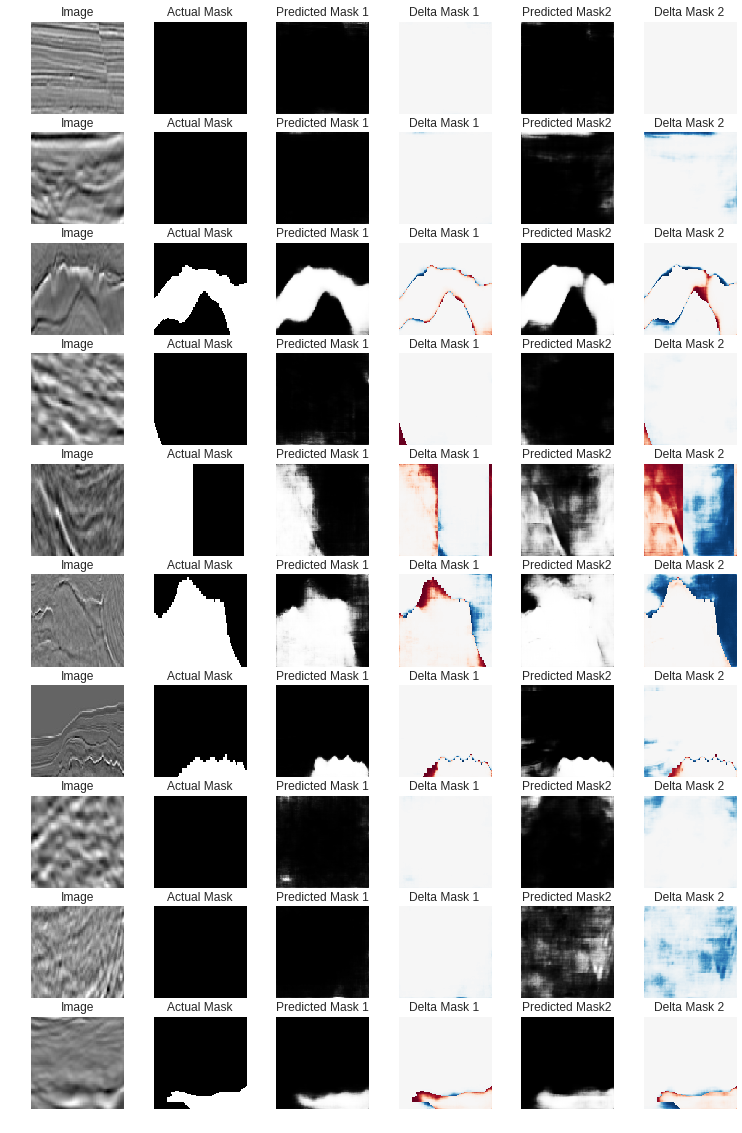

In [27]:
vis_data(train_image, train_masks, model1, model2, num_samples=10)